In [2]:
import tensorflow as tf
from Dive_into_deep_learning.d2l import tensorflow as d2l

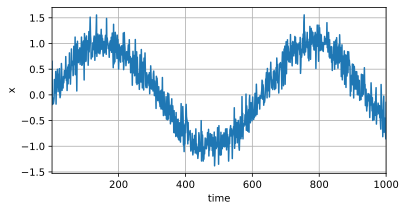

In [4]:
T = 1000
time = tf.range(1, T + 1, dtype=tf.float32)
x = tf.sin(0.01 * time) + tf.random.normal([T], 0, 0.2)
d2l.plot(time, x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [5]:
tau = 4
features = tf.Variable(tf.zeros((T - tau, tau)))
for i in range(tau):
    features[:, i].assign(x[i: T - tau + i])
labels = tf.reshape(x[tau:], (-1, 1))

batch_size, n_train = 16, 600
# 只用前N_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [6]:
# 一个简单的多层感知机
def get_net():
    net = tf.keras.Sequential([tf.keras.layers.Dense(10, activation='relu'),
                               tf.keras.layers.Dense(1)])
    return net

loss = tf.keras.losses.MeanSquaredError()

In [7]:
def train(net, train_iter, loss, epochs, lr):
    trainer = tf.keras.optimizers.Adam(lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            with tf.GradientTape() as g:
                out = net(X)
                l = loss(y, out)
                params = net.trainable_variables
                grads = g.gradient(l, params)
            trainer.apply_gradients(zip(grads, params))
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
        
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.062803
epoch 2, loss: 0.057086
epoch 3, loss: 0.053705
epoch 4, loss: 0.054627
epoch 5, loss: 0.050294


## 预测

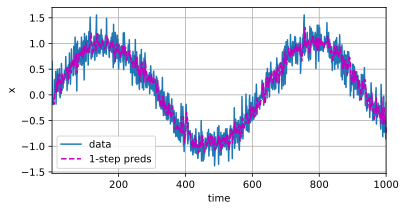

In [8]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.numpy(), onestep_preds.numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

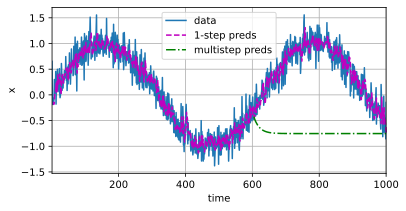

In [9]:
multistep_preds = tf.Variable(tf.zeros(T))
multistep_preds[:n_train + tau].assign(x[:n_train + tau])
for i in range(n_train + tau, T):
    multistep_preds[i].assign(tf.reshape(net(
        tf.reshape(multistep_preds[i -tau: i], (1, -1))
    ), ()))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.numpy(), onestep_preds.numpy(),
          multistep_preds[n_train + tau:].numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

## 基于k=1, 4, 16, 64，通过对整个序列预测的计算

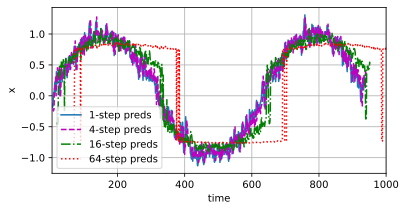

In [17]:
max_steps = 64

# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
features = tf.Variable(tf.zeros((T - tau -max_steps + 1, tau + max_steps)))
for i in range(tau):
    features[:, i].assign(x[i: i + T - tau - max_steps + 1].numpy())

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i].assign(tf.reshape(net(features[:, i - tau: i]), -1))
    
steps = [1, 4, 16, 64]
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1] for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))   